# Preliminary Panel Classifiers
---

This notebook presents the results of attempting to fit some simple classifiers to the training images.

The classifiers evaluated and their performances were:

In [200]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from skimage.transform import resize
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import glob
%matplotlib inline

## 1. Import Data, Display Sample Images

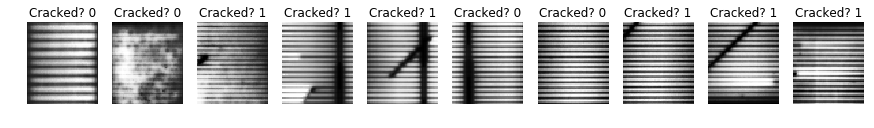

In [147]:
# Load in training_data
train_dataset = pickle.load(open('.\\data\\training_dataset.p', 'rb'))
train_labels  = pickle.load(open('.\\data\\training_labels.p', 'rb'))
valid_dataset = pickle.load(open('.\\data\\validation_dataset.p', 'rb'))
valid_labels  = pickle.load(open('.\\data\\validation_labels.p', 'rb'))

# Reshape the data
img_shape     = train_dataset[0].shape
cmp_shape     = [60, 60]
train_dataset = (np.array([resize(img, cmp_shape).flatten() for img in train_dataset]) - 128)/128
valid_dataset = (np.array([resize(img, cmp_shape).flatten() for img in valid_dataset]) - 128)/128

# Display some images
n_sample_imgs = 10
f, axs        = plt.subplots(1, n_sample_imgs, sharey = True, figsize = (15, 15/n_sample_imgs))
rnd_ix        = np.random.randint(0, train_dataset.shape[0], n_sample_imgs)
for i in range(n_sample_imgs):
    axs[i].imshow(np.reshape(train_dataset[rnd_ix[i], :], cmp_shape), cmap = 'gray')
    axs[i].set_title('Cracked? ' + str(train_labels[rnd_ix[i]]))
    axs[i].axis('off');

## 2. Dummy classifier against raw pixel intensities

In [214]:
def print_summary(name, classifier):
    print(name); print('---------------')
    print('Training set accuracy: {}'.format(accuracy_score(train_labels, classifier.predict(train_dataset))))
    print('Validation set accuracy: {}'.format(accuracy_score(valid_labels, classifier.predict(valid_dataset))))
    print('Validation set confusion_matrix:')
    print(confusion_matrix(valid_labels, classifier.predict(valid_dataset)))
    
def print_hog_summary(name, classifier):
    print(name); print('---------------')
    print('Training set accuracy: {}'.format(accuracy_score(train_labels, classifier.predict(hog_train_dataset))))
    print('Validation set accuracy: {}'.format(accuracy_score(valid_labels, classifier.predict(hog_valid_dataset))))
    print('Validation set confusion_matrix:');
    print(confusion_matrix(valid_labels, classifier.predict(hog_valid_dataset)))

In [215]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

dumc = DummyClassifier()
dumc.fit(train_dataset, train_labels)

print_summary('Dummy Classifier', dumc)

Dummy Classifier
---------------
Training set accuracy: 0.5040192926045016
Validation set accuracy: 0.5113122171945701
Validation set confusion_matrix:
[[106 102]
 [  8   5]]


## 3. Logisitic regression against raw pixel intensities

In [216]:
from sklearn.linear_model import LogisticRegression

lrc = LogisticRegression(penalty = 'l2', C = 0.1)
lrc.fit(train_dataset, train_labels)

print_summary('Logistic Regression', lrc)

Logistic Regression
---------------
Training set accuracy: 0.9991961414790996
Validation set accuracy: 0.9411764705882353
Validation set confusion_matrix:
[[208   0]
 [ 13   0]]


## 4. Random forest classifier against raw pixel intensities

In [217]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 50)
rfc.fit(train_dataset, train_labels)

print_summary('Random Forest Classifier', rfc)

Random Forest Classifier
---------------
Training set accuracy: 1.0
Validation set accuracy: 0.9411764705882353
Validation set confusion_matrix:
[[208   0]
 [ 13   0]]


## 5. RBF support vector machine against raw pixel intensities

In [218]:
from sklearn import svm

svmc = svm.SVC(kernel='rbf')
svmc.fit(train_dataset, train_labels)

print_summary('RBF SVM', svmc)

RBF SVM
---------------
Training set accuracy: 0.9364951768488746
Validation set accuracy: 0.9411764705882353
Validation set confusion_matrix:
[[208   0]
 [ 13   0]]


## 6. Using edge-based features

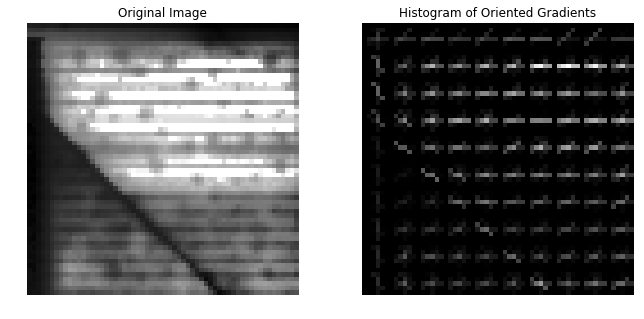

In [219]:
from skimage.feature import hog

sample_image = train_dataset[55].reshape(cmp_shape)
f, axs = plt.subplots(1, 2, figsize = (11, 5))
axs[0].imshow(sample_image, cmap = 'gray'); axs[0].axis('off'); axs[0].set_title('Original Image');

fd, hog_image = hog(sample_image, orientations=6, pixels_per_cell=(6, 6),
                    cells_per_block=(1, 1), visualise=True)
axs[1].imshow(hog_image, cmap='gray'); axs[1].axis('off'); axs[1].set_title('Histogram of Oriented Gradients');

In [220]:
def images_to_hogs(dataset):
        hog_dataset = np.array([hog(resize(img, cmp_shape), orientations = 6,
                                    pixels_per_cell = (6, 6), cells_per_block = (2, 2),
                                       visualise = False) for img in dataset])
        return hog_dataset

hog_train_dataset = images_to_hogs(pickle.load(open('.\\data\\training_dataset.p', 'rb')))
hog_valid_dataset = images_to_hogs(pickle.load(open('.\\data\\validation_dataset.p', 'rb')))

## 7. Logistic regression with HOGs

In [221]:
hlrc = LogisticRegression(penalty = 'l2', C = 0.1)
hlrc.fit(hog_train_dataset, train_labels)

print_hog_summary('Logistic Regression', hlrc)

Logistic Regression
---------------
Training set accuracy: 0.840032154340836
Validation set accuracy: 0.7149321266968326
Validation set confusion_matrix:
[[152  56]
 [  7   6]]


## 8. Random forest with HOGs

In [222]:
hrfc = RandomForestClassifier(n_estimators = 100, max_depth = 2)
hrfc.fit(hog_train_dataset, train_labels)

print_hog_summary('Random Forest Classifier', hrfc)

Random Forest Classifier
---------------
Training set accuracy: 0.8657556270096463
Validation set accuracy: 0.6832579185520362
Validation set confusion_matrix:
[[146  62]
 [  8   5]]
